![license_header_logo](https://user-images.githubusercontent.com/59526258/124226124-27125b80-db3b-11eb-8ba1-488d88018ebb.png)
> **Copyright (c) 2020-2021 CertifAI Sdn. Bhd.**<br>
 <br>
This program is part of OSRFramework. You can redistribute it and/or modify
<br>it under the terms of the GNU Affero General Public License as published by
<br>the Free Software Foundation, either version 3 of the License, or
<br>(at your option) any later version.
<br>
<br>This program is distributed in the hope that it will be useful,
<br>but WITHOUT ANY WARRANTY; without even the implied warranty of
<br>MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
<br>GNU Affero General Public License for more details.
<br>
<br>You should have received a copy of the GNU Affero General Public License
<br>along with this program.  If not, see <http://www.gnu.org/licenses/>.
<br>

## Introduction 

In this task we will build the image caption with scratch by using Pytorch and Spacy library. The dataset for this notebook is using [Flickr 8k dataset](https://www.kaggle.com/adityajn105/flickr8k) taken from Kaggle. The Flickr 8k dataset is a new benchmark collection for sentence-based image description and search, consisting of 8,000 images that are each paired with five different captions which provide clear descriptions of the salient entities and events.

## What will we accomplish?

By the end of the notebook we will be able to :
1. Combine computer vision technology with natural language processing technology.
2. Explain the concept in NLP such as word embedding and text generation by using LSTM
3. Explain the concepts in CV such as data argumentation in the image.


![image](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)
<center/><b/>Image Caption Overview</b></center>

![image](https://miro.medium.com/max/1400/1*gqKM5V-uo2sMFFPDS84yJw.png)
<center/><b/>Inception-v3 model architecture</b></center>

[Inception-v3 Details Explaination](https://sh-tsang.medium.com/review-inception-v3-1st-runner-up-image-classification-in-ilsvrc-2015-17915421f77c)

In [1]:
import os  # when loading file paths
import pandas as pd  # for lookup in annotation file
import spacy  # for tokenizer
import torch
from torch.nn.utils.rnn import pad_sequence  # pad batch
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image  # Load img
import torchvision.transforms as transforms
from torchvision import datasets
from os import listdir
import matplotlib.pyplot as plt
import warnings

In [2]:
import download

data already exists, skipping download


In [3]:
from pathlib import Path
file_dir = Path().resolve()/'flickr8k/'
image_dir = os.path.join(file_dir,'images')
caption_dir = os.path.join(file_dir,'captions.txt')

## Data Preprocessing Pipeline
![Untitled drawing](https://user-images.githubusercontent.com/59526258/134812481-678c7105-1412-4654-94be-483072eb2085.png)

In [4]:
def check_caption(file_dir,image_dir,caption_dir):
    df = pd.read_csv(caption_dir)
    img_id = df['image']
    file_list = listdir(image_dir)
    correct_list = df[img_id.isin(file_list)]
    correct_list.to_csv(file_dir/'captions.csv',index=False)
    
check_caption(file_dir,image_dir,caption_dir)   

In [5]:
spacy_eng = spacy.load("en_core_web_sm")

### Preprocess for Captions
### How we represent text as in computer
- In the context of NLP tasks, the text corpus refers to the set of texts used for the task.
- For example, if a model is build to analyze news articles, the text corpus would be the entire set of articles or papers we used to train and evaluate the model.
- The set of unique words used in the text corpus is referred to as the vocabulary

> raw text corpus → processed text → tokenized text → corpus vocabulary → text representation

![image](https://user-images.githubusercontent.com/59526258/134792560-8d1558e3-d627-42ee-ab61-0e9e0336efb2.png)
### Word Embedding
- Word embeddings are a type of word representation that allows words with similar meaning to have a similar representation.
- Embedding refer to learning this mapping from one discrete type to a point in the vector space.
![image](https://user-images.githubusercontent.com/59526258/134792488-51ba574d-1895-4572-b6df-59defb042727.png)
![image](https://miro.medium.com/max/875/1*Y7K_-6HZqbii1V8Ms6SALQ.gif)

In [6]:
# To map each word to a index, convert string to numerical value
class Vocabulary:
    def __init__(self, freq_threshold):
        # freq_threshold check the freq word in text, if 1 , may not important to us
        # <UNK> if the word freq appear is less than threshold, it will map to <UNK>
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    
    # tokenize the caption [I love coffee] -> ["i","love","coffee"] 
    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]
    
    # build vocab
    def build_vocabulary(self, sentence_list):
        # count each caption how many times a specific word repeated
        # if over the threshold we will include it, else ignore it
        frequencies = {}
        # start with index 4 because we have include the tagging
        idx = 4
        
        #self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>", 4: "i"}
        #self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3, "i":4}

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1 
                # if the word frequence is we want,(we just need to append 1 times only)
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1 # store word to next index
        
    # convert text into number
    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)
        

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] # if word is not in library, <UNK>
            for token in tokenized_text
        ]


In [7]:
# we must make sure very caption have the same length to make sure LSTM input
# use custom MyCollate
def pad_collate_function(batch):
    imgs = [item[0].unsqueeze(0) for item in batch]
    imgs = torch.cat(imgs, dim=0)
    targets = [item[1] for item in batch]
    targets = pad_sequence(targets, batch_first=False, padding_value=0)
    return imgs, targets

### Preprocess for Image

In [8]:
import torchvision.transforms as transforms
transform = transforms.Compose(
        [
            transforms.Resize((356, 356)),
            # the inception take input size of 299,299
            transforms.RandomCrop((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

## Data Loader

In [9]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=transform, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform

        # Get img, caption columns
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]

        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        # Send all the caption as list
        self.vocab.build_vocabulary(self.captions.tolist())

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])
        
        return img, torch.tensor(numericalized_caption)

In [10]:
dataset = FlickrDataset(image_dir, os.path.join(file_dir,'captions.csv')) 
next(iter(dataset))

(tensor([[[-0.1451, -0.1686, -0.1843,  ..., -0.7882, -0.8980, -0.8980],
          [-0.1294, -0.1529, -0.1608,  ..., -0.7804, -0.8510, -0.8667],
          [-0.1294, -0.1451, -0.1529,  ..., -0.8431, -0.8431, -0.8745],
          ...,
          [-0.8980, -0.9137, -0.8980,  ..., -0.5765, -0.6941, -0.7098],
          [-0.8980, -0.8745, -0.8039,  ..., -0.6706, -0.8431, -0.8275],
          [-0.8275, -0.7961, -0.7961,  ..., -0.6941, -0.8745, -0.7569]],
 
         [[-0.0824, -0.1059, -0.1216,  ..., -0.7020, -0.7569, -0.7255],
          [-0.0745, -0.0824, -0.0980,  ..., -0.7412, -0.7804, -0.7020],
          [-0.0588, -0.0667, -0.0902,  ..., -0.7176, -0.6863, -0.7412],
          ...,
          [-0.8980, -0.8824, -0.8980,  ..., -0.7490, -0.7961, -0.7961],
          [-0.8980, -0.8745, -0.8275,  ..., -0.7647, -0.8510, -0.8510],
          [-0.8353, -0.8196, -0.8353,  ..., -0.7804, -0.8510, -0.7961]],
 
         [[-0.2627, -0.2863, -0.3020,  ..., -0.8902, -0.9529, -0.9686],
          [-0.2392, -0.2627,

In [11]:
train_size = int(0.8 * len(dataset))
test_size = int(0.1 * len(dataset))
val_size = int(0.1 * len(dataset))
train, test, val = random_split(dataset, [train_size,test_size,val_size], generator=torch.Generator().manual_seed(123))

## Data Batching

In [12]:
# If GPU ran out of memory use lower batch_size such as 8, 16, 32
batch_size = 64

train_iter = DataLoader(
    dataset=train,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=pad_collate_function,
generator = torch.Generator().manual_seed(123))

test_iter = DataLoader(
    dataset=test,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=pad_collate_function,
generator = torch.Generator().manual_seed(123))

valid_iter = DataLoader(
    dataset=val,
    batch_size=1,
    shuffle=False,
    collate_fn=pad_collate_function,
generator = torch.Generator().manual_seed(123))

## Model Configuration

In [13]:
import torch
import torch.nn as nn
import statistics
import torchvision.models as models

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        # Use pretrain model and fine tune last layer model
        #change to resnet and see 
        self.inception = models.inception_v3(pretrained=True, aux_logits=False)
        # Map to embed size
        self.inception.fc = nn.Linear(self.inception.fc.in_features, embed_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
        # image shape (channel,height,width) -> [3, 299, 299]
        features = self.inception(images)
        return self.dropout(self.relu(features))


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        # Embedding layer - map word vector to better dimension space
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        # captions shape: (seq_length, N) N-> batch size
        # embeddings shape: (seq_length, N,embedding_size = 256)
        
        embeddings = self.dropout(self.embed(captions))
        # it will take like first word to the LSTM
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs


class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs
    
    # This method use when in inference
    def caption_image(self, image, vocabulary, max_length=50):
        # image shape # batch size, channel, height, weight
        result_caption = []
        outputs = []


        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None

            for _ in range(max_length):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                outputs.append(output)
                # Select the highest probabilies as the word for particular timestep 
                predicted = output.argmax(1)
                # Each predicted is 1 word
                result_caption.append(predicted.item())

                # Next word to input to lstm, repeat the loop
                x = self.decoderRNN.embed(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break
                    
        return [vocabulary.itos[idx] for idx in result_caption]


In [14]:
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
from torchsummaryX import summary
import torch.optim as optim
# Hyperparameters
embed_size = 64
hidden_size = 64
vocab_size = len(dataset.vocab)
num_layers = 1
learning_rate = 3e-4
num_epochs = 60

# initialize model, loss etc
model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
# Ignore the pad index
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### Print summary for EncoderCNN

In [16]:
warnings.filterwarnings("ignore")
from torchsummaryX import summary
inputs1 = torch.zeros((1,3, 299, 299),dtype=torch.float) # batch size, channel, height, weight

print(summary(EncoderCNN(embed_size),inputs1))

                                                         Kernel Shape  \
Layer                                                                   
0_inception.Conv2d_1a_3x3.Conv2d_conv                   [3, 32, 3, 3]   
1_inception.Conv2d_1a_3x3.BatchNorm2d_bn                         [32]   
2_inception.Conv2d_2a_3x3.Conv2d_conv                  [32, 32, 3, 3]   
3_inception.Conv2d_2a_3x3.BatchNorm2d_bn                         [32]   
4_inception.Conv2d_2b_3x3.Conv2d_conv                  [32, 64, 3, 3]   
5_inception.Conv2d_2b_3x3.BatchNorm2d_bn                         [64]   
6_inception.MaxPool2d_maxpool1                                      -   
7_inception.Conv2d_3b_1x1.Conv2d_conv                  [64, 80, 1, 1]   
8_inception.Conv2d_3b_1x1.BatchNorm2d_bn                         [80]   
9_inception.Conv2d_4a_3x3.Conv2d_conv                 [80, 192, 3, 3]   
10_inception.Conv2d_4a_3x3.BatchNorm2d_bn                       [192]   
11_inception.MaxPool2d_maxpool2                    

### Print summary for DecoderRNN

In [17]:
warnings.filterwarnings("ignore")
inputs2 = torch.zeros((batch_size, embed_size),dtype = torch.int) # batch size, embed_size after EncoderCNN relu
inputs3 = torch.zeros((24, batch_size),dtype = torch.int) # seq_length,batch size
# 1783->vacab size
print(summary(DecoderRNN(embed_size,hidden_size,vocab_size,num_layers),inputs2,inputs3))

          Kernel Shape    Output Shape    Params Mult-Adds
Layer                                                     
0_embed     [64, 1783]    [24, 64, 64]  114.112k  114.112k
1_dropout            -    [24, 64, 64]         -         -
2_lstm               -    [25, 64, 64]    33.28k   32.768k
3_linear    [64, 1783]  [25, 64, 1783]  115.895k  114.112k
-----------------------------------------------------------
                        Totals
Total params          263.287k
Trainable params      263.287k
Non-trainable params       0.0
Mult-Adds             260.992k
          Kernel Shape    Output Shape    Params  Mult-Adds
Layer                                                      
0_embed     [64, 1783]    [24, 64, 64]  114112.0   114112.0
1_dropout            -    [24, 64, 64]       NaN        NaN
2_lstm               -    [25, 64, 64]   33280.0    32768.0
3_linear    [64, 1783]  [25, 64, 1783]  115895.0   114112.0


### Print summary for CNNtoRNN

In [18]:
inputs4 = torch.zeros((64, 3, 299, 299),dtype = torch.int) # batch size, channel, height, weight 
inputs5 = torch.zeros((35, 64),dtype = torch.int) # seq_length,batch size
model_summary = CNNtoRNN(embed_size,hidden_size,vocab_size,num_layers)
print(summary(model_summary,inputs4,inputs5))

                                                         Kernel Shape  \
Layer                                                                   
0_encoderCNN.inception.Conv2d_1a_3x3.Conv2d_conv        [3, 32, 3, 3]   
1_encoderCNN.inception.Conv2d_1a_3x3.BatchNorm2...               [32]   
2_encoderCNN.inception.Conv2d_2a_3x3.Conv2d_conv       [32, 32, 3, 3]   
3_encoderCNN.inception.Conv2d_2a_3x3.BatchNorm2...               [32]   
4_encoderCNN.inception.Conv2d_2b_3x3.Conv2d_conv       [32, 64, 3, 3]   
5_encoderCNN.inception.Conv2d_2b_3x3.BatchNorm2...               [64]   
6_encoderCNN.inception.MaxPool2d_maxpool1                           -   
7_encoderCNN.inception.Conv2d_3b_1x1.Conv2d_conv       [64, 80, 1, 1]   
8_encoderCNN.inception.Conv2d_3b_1x1.BatchNorm2...               [80]   
9_encoderCNN.inception.Conv2d_4a_3x3.Conv2d_conv      [80, 192, 3, 3]   
10_encoderCNN.inception.Conv2d_4a_3x3.BatchNorm...              [192]   
11_encoderCNN.inception.MaxPool2d_maxpool2         

## Model Traininig

In [19]:
def training(model, iterator, optimizer, criterion):
    torch.manual_seed(123)
    epoch_loss = 0
    train_CNN = False
    # Freeze all the layer except the last FC layer
    for name, param in model.encoderCNN.inception.named_parameters():
        if "fc.weight" in name or "fc.bias" in name:
            param.requires_grad = True
        else:
            param.requires_grad = train_CNN

    model.train()

    for imgs,captions in iterator:
        imgs = imgs.to(device)
        captions = captions.to(device)

        optimizer.zero_grad()
        # We want model to predict end token, so will not sent in
        outputs = model(imgs, captions[:-1])
        
        # we predict each example, we predict in different timestep,
        # 1 example may have 20 words 
        # each word have it logic corresponding to vocab
        # (seq_len, batch_size , vocabulary_size) each word will have corresponding probabilities
        # concate into (seq_len, batch_size) to make each timestep as example

        loss = criterion(
            outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
        )

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [20]:
def evaluate(model, iterator, criterion,dataset):
    torch.manual_seed(123)
    epoch_loss = 0

    model.eval()

    with torch.no_grad():

        for imgs,captions in iterator:
            imgs = imgs.to(device)
            captions = captions.to(device)
            outputs = model(imgs, captions[:-1])            

            loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1))

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [21]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [22]:
def learning_curve(num_epochs, train_status, val_status, title, y_label):
    plt.figure(figsize=(10, 6))
    plt.grid()
    ax_title = title.split()
    plt.plot(train_status, label="Training")
    plt.plot(val_status, label="Validate")
    plt.xlabel("Epoch")
    plt.ylabel(y_label)
    plt.legend()
    plt.title(title)
    plt.show()

In [23]:
model_saving_path = os.path.join(file_dir,'image_caption_dict.pt')
if(os.path.exists(model_saving_path)==False):
    train_loss_list = []
    valid_loss_list = []
    train_acc_list = []
    valid_acc_list = []
    torch.manual_seed(123)
    for epoch in range(num_epochs):

        start_time = time.time()

        train_loss = training(model, train_iter, optimizer, criterion)
        valid_loss = evaluate(model, test_iter, criterion,dataset)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)

        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f}')
        
    learning_curve(num_epochs, train_loss_list, valid_loss_list,
               title="Train Loss & Validate Loss", y_label="Loss")
    
    torch.save(model.state_dict(),model_saving_path)
else:
    model.load_state_dict(torch.load(model_saving_path))

## Evaluation

In [24]:
valid_loss = evaluate(model, valid_iter, criterion,dataset)
valid_loss

2.7466337021257057

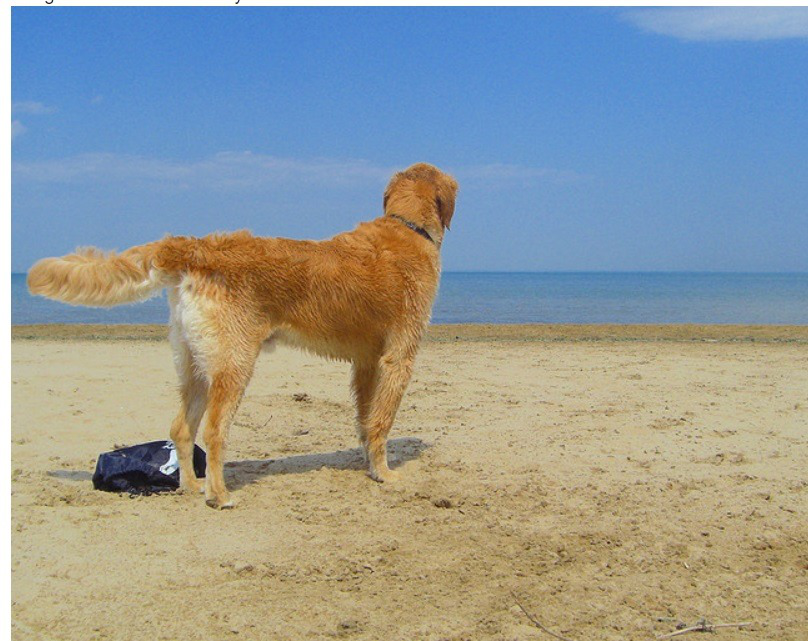

Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the grass . <EOS>


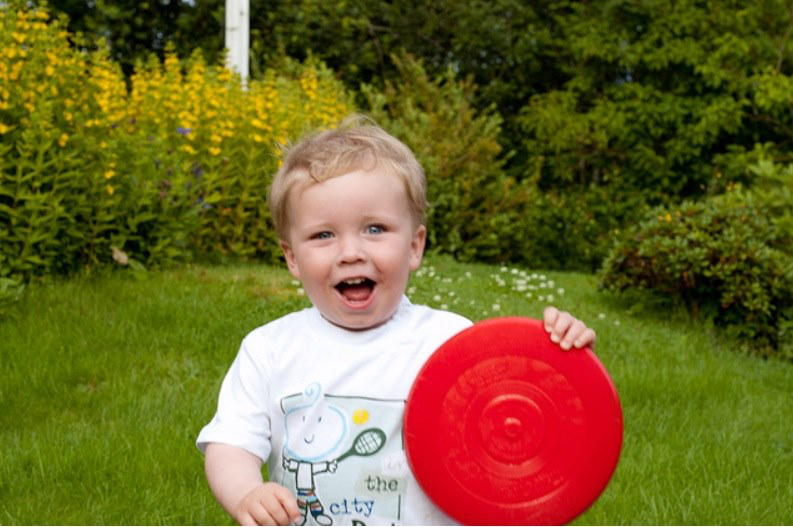

Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>


In [25]:
transform = transforms.Compose(
        [
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )
model.load_state_dict(torch.load(model_saving_path))
model.eval()
sample_image = Image.open("test_examples/dog.jpg")
display(sample_image)
test_img1 = transform(sample_image.convert("RGB")).unsqueeze(0)

print("Example 1 CORRECT: Dog on a beach by the ocean")
text = model.caption_image(test_img1.to(device), dataset.vocab)
print("Example 1 OUTPUT: "+ " ".join(text))

sample_image_2 = Image.open("test_examples/child.jpg")
test_img2 = transform(sample_image_2.convert("RGB")).unsqueeze(0)
display(sample_image_2)
print("Example 2 CORRECT: Child holding red frisbee outdoors")
print(
    "Example 2 OUTPUT: "
    + " ".join(model.caption_image(test_img2.to(device), dataset.vocab))
)

## Reference
1. [How to Create a Vocabulary for NLP Tasks in Python](https://www.kdnuggets.com/2019/11/create-vocabulary-nlp-tasks-python.html)
2. [But what are PyTorch DataLoaders really?](https://www.scottcondron.com/jupyter/visualisation/audio/2020/12/02/dataloaders-samplers-collate.html)
3. [How to build custom Datasets for Text in Pytorch](https://www.youtube.com/watch?v=9sHcLvVXsns)